# Uber Pick-Ups Clustering

**Goal : Showing hot-zones for uber pick-ups in NYC**

## 1. First look at the data

In [1]:
import math
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
import kaleido
import warnings
warnings.filterwarnings("ignore")

For dataset sizes purposes, we choose to focus only on one month (September 2014).

In [2]:
data_apr_14 = pd.read_csv('./data/uber-raw-data-sep14.csv')
data_apr_14

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512
...,...,...,...,...
1028131,9/30/2014 22:57:00,40.7668,-73.9845,B02764
1028132,9/30/2014 22:57:00,40.6911,-74.1773,B02764
1028133,9/30/2014 22:58:00,40.8519,-73.9319,B02764
1028134,9/30/2014 22:58:00,40.7081,-74.0066,B02764


**One line in the dataset corresponds to one pick-up request from a client.**

## 2. Preprocessing of the data

### 2.1. Dates and time basic preprocessing

In [3]:
%%time

SAMPLE_SIZE = 300000
# this cell can take a few minutes to run dependingon the sample size

data = data_apr_14.drop('Base', axis = 1) # drop unuseful column
data = data.sample(SAMPLE_SIZE, random_state = 0) # data sampling for faster computing

# datetime processings
data['Date/Time'] = pd.to_datetime(data['Date/Time'])
data['day'] = data['Date/Time'].dt.day
data['dayofweek'] = data['Date/Time'].dt.dayofweek
data['hour'] = data['Date/Time'].dt.hour
data['Date/Hour'] = data['Date/Time'].dt.floor('H') # Drop the minutes/seconds/level of precision
data['DayOfWeek'] = data['Date/Hour'].dt.strftime('%A')

# Convert timestamps to string in order to be able to use it as labels in figures
data['Hour'] = data['Date/Hour'].dt.strftime('%H:%M:00')
data['DayOfWeek/Hour'] = data['Date/Hour'].dt.strftime('%A-%H:%M:00') 
data['Date/Hour'] = data['Date/Hour'].dt.strftime('%Y-%m-%d-%H:%M:00')

# Order the values to correspond to the order of looping for vizualisations
data = data.sort_values(['hour','dayofweek'], ascending = [True,True]) 

data

CPU times: user 32.6 s, sys: 281 ms, total: 32.9 s
Wall time: 32.9 s


,Date/Time,Lat,Lon,day,dayofweek,hour,Date/Hour,DayOfWeek,Hour,DayOfWeek/Hour
14,2014-09-01 00:48:00,40.7378,-74.0395,1,0,0,2014-09-01-00:00:00,Monday,00:00:00,Monday-00:00:00
150425,2014-09-15 00:18:00,40.7325,-73.9991,15,0,0,2014-09-15-00:00:00,Monday,00:00:00,Monday-00:00:00
631274,2014-09-29 00:13:00,40.7500,-73.9980,29,0,0,2014-09-29-00:00:00,Monday,00:00:00,Monday-00:00:00
366563,2014-09-08 00:55:00,40.7523,-73.9744,8,0,0,2014-09-08-00:00:00,Monday,00:00:00,Monday-00:00:00
34385,2014-09-01 00:05:00,40.7257,-73.9900,1,0,0,2014-09-01-00:00:00,Monday,00:00:00,Monday-00:00:00
...,...,...,...,...,...,...,...,...,...,...
548749,2014-09-21 23:07:00,40.7636,-73.9768,21,6,23,2014-09-21-23:00:00,Sunday,23:00:00,Sunday-23:00:00
548845,2014-09-21 23:33:00,40.8053,-73.9529,21,6,23,2014-09-21-23:00:00,Sunday,23:00:00,Sunday-23:00:00
838317,2014-09-28 23:11:00,40.6468,-73.7894,28,6,23,2014-09-28-23:00:00,Sunday,23:00:00,Sunday-23:00:00
962903,2014-09-21 23:11:00,40.7707,-73.8658,21,6,23,2014-09-21-23:00:00,Sunday,23:00:00,Sunday-23:00:00


### 2.2. Data Exploration - Choosing the timeframes

Information that could be interesting for Uber is the localization of clusters condensing significant part of the demand, for a given timeframe. 
It remains to be determined how we mesh the time and choose the timeframe to visualize our clusters.  
To choose the best timeframe, we first observe the overall evolution in time of the number of pick-up requests by clients. 

In [4]:
# Get the first monday in datetime format to begin the weekly x-axis grid

mondays_dt = data[data['DayOfWeek/Hour'].str.contains('Monday')]['Date/Time'].dt.date
first_monday_dt = mondays_dt.loc[mondays_dt.index[0]]
first_monday_dt

datetime.date(2014, 9, 1)

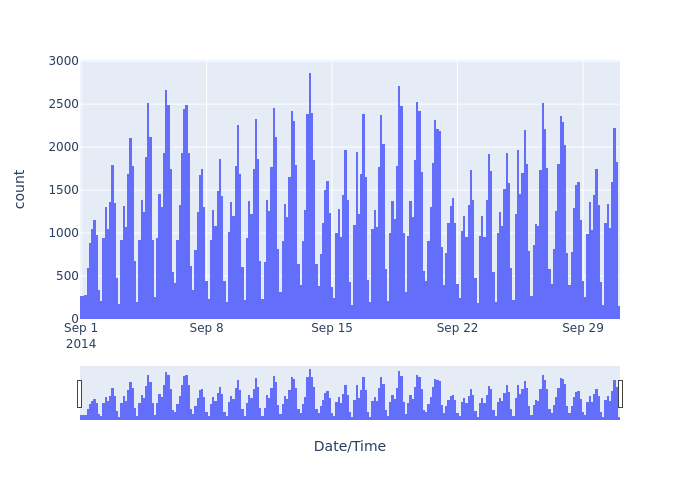

In [5]:
# Show evolution of demand as a function of time

fig = px.histogram(data, x = 'Date/Time')
fig.update_xaxes(tick0 = first_monday_dt, dtick = 86400000*7, showgrid=True, # A one-day tick width is 86400000 according to the documentation => we choose one tick = one week
                 rangeslider = go.layout.xaxis.Rangeslider(visible = True)) 

file_name = 'Evolution_of_demand_over_time.html'
dir_name = 'figures'
path = f"{dir_name}/{file_name}"
fig.write_html(path) # saving interactive figure in html file
fig.show('png') # showing non-interactive preview for github

Looking at the histogram of demand as a function of time, **we can sense some seasonality on the same weekdays of different weeks, and some other on the same hours of different days**.

And we will guess that the differences that make the data non-perfectly periodical rely less on the day in month itself than on all sorts of events and variables such as local cultural agenda, exceptionnal events, meteorology... All sorts of variables on which we don't have any data, we will thus consider them as random variations that can't be predicted/anticipated in our scope. 

=> We can't be sure it will be pertinent to present to Uber the information of clusters for all days of month, because we would not be able to guarantee any reproductibility from a month to another (i.e. we wouldn't be sure having only the information on hotzones for the 26th of April would help us predicting the hotzones for the 26th of May for instance.)

=> **A more relevant scope of analysis would be to look for the hotzones with a timeframe being the weekday instead of the day of month.** It would give us the information of the hotzones in "an average Monday", "average Tuesday"... etc in the month. 

In addition, we will mesh the time feature more precisely if we compute the clusters not only for each given day of week but for each given {day of week, hour} combination. 

**=> We hence choose the {day of week, hour} combination as the timeframe used to split our data in order to run a clustering for each timeframe. Each clustering will be fed only with geolocalization data (latitude and longitude)**

In [6]:
columns_to_keep = ['Lat', 'Lon', 'DayOfWeek/Hour']
data = data[columns_to_keep]
data

,Lat,Lon,DayOfWeek/Hour
14,40.7378,-74.0395,Monday-00:00:00
150425,40.7325,-73.9991,Monday-00:00:00
631274,40.7500,-73.9980,Monday-00:00:00
366563,40.7523,-73.9744,Monday-00:00:00
34385,40.7257,-73.9900,Monday-00:00:00
...,...,...,...
548749,40.7636,-73.9768,Sunday-23:00:00
548845,40.8053,-73.9529,Sunday-23:00:00
838317,40.6468,-73.7894,Sunday-23:00:00
962903,40.7707,-73.8658,Sunday-23:00:00


### 2.3. Distances preprocessings

As chosen before, the only features that we will feed to our clustering algorithms are latitude and longitude.   
In this project, we want to reason on road distances, and **we want to assign the exact same importance to the distance travelled in a direction than in another.** 

To achieve this the more realistically possible : 
- **We choose NOT to normalize the data**, as normalizing could have an effect of "shrinking" a direction more than the other. For example : if we have for some reason a bigger variance in latitude than in longitude, the effect of normalizing data will resulting in considering, for two points that are exactly at the same distance in the two directions, that the points are closer in latitude than in longitude.
- **We will not use directly the latitude and longitude values, but their equivalent in distance**. Indeed, as NYC is located at approx. a latitude of 40° from the equator, 1° in latitude does not correspond to the same distance (approx. 111km) as 1° in longitude (approx. 85km).

In [7]:
# Create new features that represent distances in 100 kilometers unit 
# (we use the 100km unit rather than the km unit to avoid feeding too big numbers to the algorithms) 
data['x'] = data['Lon'] * 111.320 * np.cos(np.radians(data['Lat'])) / 100                               # transform longitude
data['y'] = data['Lat'] * 110.574 / 100                                                                 # transform latitude

# Define these 2 features are the ones that will be fed to the clustering algorithms
clustering_features = ['x','y']
data

,Lat,Lon,DayOfWeek/Hour,x,y
14,40.7378,-74.0395,Monday-00:00:00,-62.450545,45.045415
150425,40.7325,-73.9991,Monday-00:00:00,-62.421441,45.039555
631274,40.7500,-73.9980,Monday-00:00:00,-62.404093,45.058905
366563,40.7523,-73.9744,Monday-00:00:00,-62.382032,45.061448
34385,40.7257,-73.9900,Monday-00:00:00,-62.420143,45.032036
...,...,...,...,...,...
548749,40.7636,-73.9768,Sunday-23:00:00,-62.373453,45.073943
548845,40.8053,-73.9529,Sunday-23:00:00,-62.314164,45.120052
838317,40.6468,-73.7894,Sunday-23:00:00,-62.324653,44.944793
962903,40.7707,-73.8658,Sunday-23:00:00,-62.273210,45.081794


### 2.4 Splitting the data along timeframes

In [8]:
# Splitting the data by timeframes : an independant clustering will be run on each timeframe

timeframes = data['DayOfWeek/Hour'].unique()
timeframe_data_list = []
for timeframe in timeframes:
    timeframe_data_list.append(data[data['DayOfWeek/Hour'] == timeframe])
print("Number of timeframes: ", len(timeframe_data_list))
print("Showing some examples:")
timeframe_data_list[:3]

Number of timeframes:  168
Showing some examples:


[            Lat      Lon   DayOfWeek/Hour          x          y
 14      40.7378 -74.0395  Monday-00:00:00 -62.450545  45.045415
 150425  40.7325 -73.9991  Monday-00:00:00 -62.421441  45.039555
 631274  40.7500 -73.9980  Monday-00:00:00 -62.404093  45.058905
 366563  40.7523 -73.9744  Monday-00:00:00 -62.382032  45.061448
 34385   40.7257 -73.9900  Monday-00:00:00 -62.420143  45.032036
 ...         ...      ...              ...        ...        ...
 962981  40.7193 -73.9937  Monday-00:00:00 -62.429267  45.024959
 652766  40.7168 -73.9522  Monday-00:00:00 -62.396596  45.022194
 459422  40.7716 -73.9822  Monday-00:00:00 -62.370497  45.082789
 795470  40.7637 -73.9816  Monday-00:00:00 -62.377406  45.074054
 26147   40.7198 -74.0001  Monday-00:00:00 -62.434198  45.025512
 
 [537 rows x 5 columns],
              Lat      Lon    DayOfWeek/Hour          x          y
 968364   40.7504 -73.9912  Tuesday-00:00:00 -62.397983  45.059347
 157358   40.7292 -73.9891  Tuesday-00:00:00 -62.416101  45

## 3. Clustering - Comparing KMeans and DBSCAN methods

### 3.1. KMeans

#### 3.1.1. Choosing the optimal number of clusters

The only hyperparameter that has to be defined for running a KMeans algorithm is the number of clusters 'k'. 
It can be difficult to find at first sight the number that would be the more adequate, and it could vary among timeframes. 
=> We choose to run for each timeframe 9 KMeans algorithm (each one with the k hyperparameter between 2 and 10), and for each both the silhouette score and the WCSS inertia. 

- The lower the WCSS inertia is, the closer the points of one given cluster are close from each other, we want to find an optimal 'k' with a low inertia (to allow drivers not to have to drive too far away to find clients)
- Also, the higher the silhouette score is, the better the partition between clusters is, we would also want to keep this score as high as possible. 

**=> To get the better compromise between the 2, we will scale these 2 characteristics and take for each timeframe the 'k' that maximizes the `score = scaled silhouette score - scaled WCSS inertia`, and keep the corresponding k hyperparameter.**

In [9]:
# Identifying for each timeframe the better number of clusters to use

print(f"Finding the optimum k hyperparameter for each of the {len(timeframe_data_list)} timeframes :")

timeframes_nb = len(timeframe_data_list)
progress_percents_to_display = list(range(5, 100, 5))
indexes_to_display_progress = np.ceil([timeframes_nb * percent / 100 for percent in progress_percents_to_display])

optimum_k_list = []
sc = StandardScaler()

for i in range(timeframes_nb):
    wcss_list = []
    sil_list = []
    k_list = []
    for k in range(2,10+1):
        X = timeframe_data_list[i][clustering_features]
        kmeans = KMeans(n_clusters = k, random_state = 0)
        kmeans.fit(X)
        wcss_list.append(kmeans.inertia_)
        sil_list.append(silhouette_score(X, kmeans.predict(X)))
        k_list.append(k)
        
    k_choice = pd.DataFrame({'k':k_list, 'WCSS':wcss_list, 'Silhouette Score':sil_list}).set_index('k')
    k_choice_scaled = sc.fit_transform(k_choice)
    k_choice['score'] = k_choice_scaled[:,1] - k_choice_scaled[:,0]
    optimum_k = k_choice.index[k_choice['score'].argmax()]
    optimum_k_list.append(optimum_k)

    if i+1 in indexes_to_display_progress:  
        print(int(((i+1)/timeframes_nb) * 100), "% complete", end = '\r')  # display progress percentage every 5%
print("Done !                ")

Finding the optimum k hyperparameter for each of the 168 timeframes :
Done !                


#### 3.1.2. Computing the algorithm

In [10]:
# Run optimized KMeanss on each timeframe
 
print(f"Fitting one KMeans on each of the {len(timeframe_data_list)} timeframes :") 

for i in range(timeframes_nb):
    kmeans = KMeans(n_clusters = optimum_k_list[i], random_state = 0)
    kmeans.fit(timeframe_data_list[i][clustering_features])
    timeframe_data_list[i]['cluster'] = kmeans.labels_
    timeframe_data_list[i] = timeframe_data_list[i].sort_values('cluster')
    if i+1 in indexes_to_display_progress:  
        print(int(((i+1)/timeframes_nb) * 100), "% complete", end = '\r')  # display progress percentage every 5%
print("Done !                 ")

Fitting one KMeans on each of the 168 timeframes :
Done !                 


#### 3.1.3. Processings for vizualisation

In [11]:
timeframe_summary_list = []

for timeframe_data in timeframe_data_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the timeframe, and the % of the timeframe demand it represents:
    timeframe_demand = len(timeframe_data)
    clusters_size = timeframe_data.groupby(['DayOfWeek/Hour', 'cluster']).count()['Lat'].rename('count').reset_index(drop = False)
    clusters_size['%_of_timeframe_demand'] = (clusters_size['count'] / timeframe_demand * 100).astype(int)
    
    # Merge the information in each timeframe:
    timeframe_summary = timeframe_data.merge(clusters_size, on = ['DayOfWeek/Hour', 'cluster'])
    
    # Create a column with the text to display for each cluster in the timeframe: 
    timeframe_summary['cluster / % of demand'] = '#' + timeframe_summary['cluster'].astype(str) + ' / ' + timeframe_summary['%_of_timeframe_demand'].astype(str) + '%'
    
    # Splitting the timeframe identification in two (day of week, hour) to monitor one in the subplots and the other in the slider in the plotly figure
    timeframe_summary['DayOfWeek'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[0]
    timeframe_summary['Hour'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[2]
    
    timeframe_summary_list.append(timeframe_summary)

Example for a given timeframe :


,Lat,Lon,DayOfWeek/Hour,x,y,cluster,count,%_of_timeframe_demand,cluster / % of demand,DayOfWeek,Hour
0,40.7572,-73.8054,Tuesday-07:00:00,-62.234929,45.066866,0,143,5,#0 / 5%,Tuesday,07:00:00
1,40.8672,-73.9742,Tuesday-07:00:00,-62.273937,45.188498,0,143,5,#0 / 5%,Tuesday,07:00:00
2,40.8681,-73.8816,Tuesday-07:00:00,-62.195138,45.189493,0,143,5,#0 / 5%,Tuesday,07:00:00
3,40.7740,-73.8715,Tuesday-07:00:00,-62.274922,45.085443,0,143,5,#0 / 5%,Tuesday,07:00:00
4,40.7732,-73.8856,Tuesday-07:00:00,-62.287559,45.084558,0,143,5,#0 / 5%,Tuesday,07:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2751,40.6921,-74.1814,Tuesday-07:00:00,-62.613198,44.994883,3,80,2,#3 / 2%,Tuesday,07:00:00
2752,40.6660,-73.9790,Tuesday-07:00:00,-62.466814,44.966023,3,80,2,#3 / 2%,Tuesday,07:00:00
2753,40.6880,-74.1829,Tuesday-07:00:00,-62.618317,44.990349,3,80,2,#3 / 2%,Tuesday,07:00:00
2754,40.6139,-73.9756,Tuesday-07:00:00,-62.512714,44.908414,3,80,2,#3 / 2%,Tuesday,07:00:00


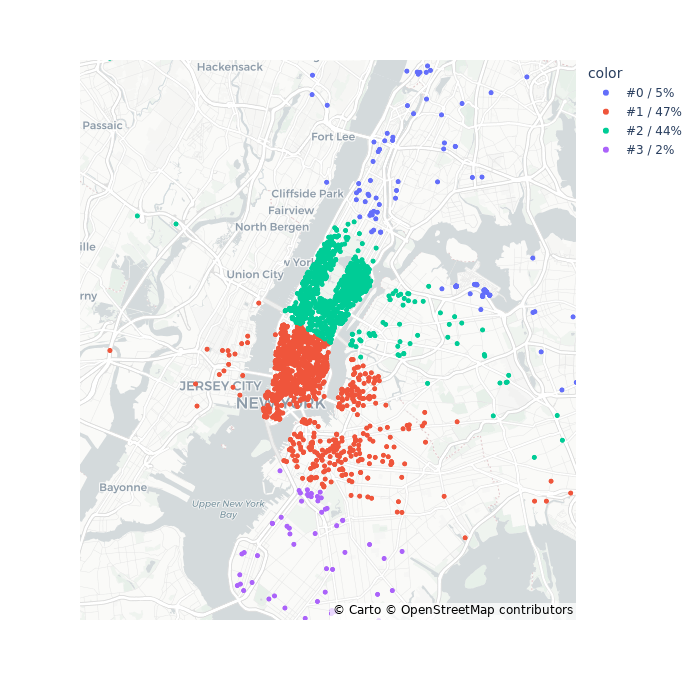

In [12]:
print("Example for a given timeframe :")
timeframe_example = timeframe_summary_list[50]
display(timeframe_example)
fig = px.scatter_mapbox(timeframe_example, lat = 'Lat', lon = 'Lon', 
                      mapbox_style="carto-positron", 
                      color = timeframe_example['cluster / % of demand'].astype(str), 
                      height = 700, zoom = 10
                     )
fig.show('png')

#### 3.1.4. Final visualizations

Figure created in figures/KMeans_clustering.html


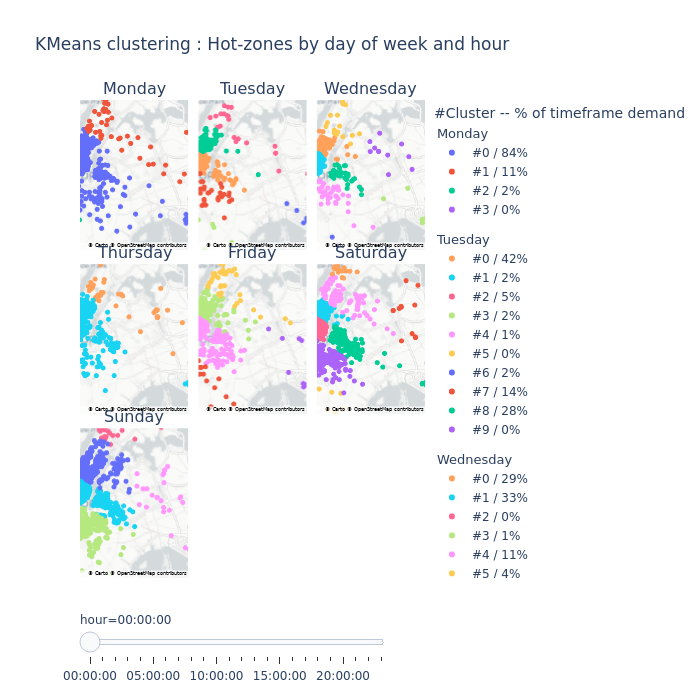

In [13]:
# Create one subplot per day of week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figs = sp.make_subplots(rows = int(math.ceil(len(days_of_week)/3)), cols = 3, subplot_titles = days_of_week, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {}, {}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 40.712559, 'lon': -73.889029},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each day mapbox
for day_index in range(len(days_of_week)):
    figs.update_layout({f'mapbox{day_index+1}' : default_mapbox_dict})

# Slider initialization
slider_dict = {'active': 0,
               'currentvalue': {'prefix': 'hour='},
               'len': 0.9,
               'pad': {'b': 10, 't': 30},
               'steps': []
              }

# Initialize timeframe, traces list

timeframe_index = 0
traces_hour_index = [] # initialize a list which will associate to each trace its corresponding hour index for later use in interactive mask (slider)

# Fill the data for each trace (1 trace per different {hour, day, cluster} combination existing in the data)
# 1. Loop on frames (hours)

hour_names = ["{:0>2d}:00:00".format(hour_index) for hour_index in range(24)] 
for hour_index in range(24):

    # 2. Loop on subplots (days of week)

    for day_index, day in enumerate(days_of_week):
        subplot_data = timeframe_summary_list[timeframe_index]
        row_number = i//3 + 1
        col_number = i%3 + 1

        # 3. Loop on traces (clusters)

        for cluster in subplot_data['cluster'].unique():
            cluster_data = subplot_data[subplot_data['cluster']==cluster]
            if len(cluster_data['cluster / % of demand'].unique()) != 0:
                cluster_name = cluster_data['cluster / % of demand'].unique()[0]
            else: 
                cluster_name = 'no cluster found'
            data_dict = {
                'type' : 'scattermapbox',
                'text': hour_names[hour_index],
                'hoverinfo': 'all',
                'name': cluster_name,
                'subplot': f'mapbox{day_index+1}',
                'lat' : subplot_data['Lat'][subplot_data['cluster'] == cluster],
                'lon' : subplot_data['Lon'][subplot_data['cluster'] == cluster],
                'legendgrouptitle' : {'text' : day},
                'legendgroup' : day,
                'showlegend' : True,
                'visible' : False # set each trace default to invisible since the slider will set which trace is visible
            }
            if hour_index == 0:
                data_dict['visible'] = True # Set the traces of the first hour default to visible
            figs.add_trace(data_dict)
            traces_hour_index.append(hour_index)
            print(f"Trace created for Hour : {hour_index}, Day : {day}, Cluster : {cluster}")
            clear_output(wait = True)
        timeframe_index += 1

# Create steps of the slider

for hour_index in range(24):
    mask = [True if x == hour_index else False for x in traces_hour_index]
    step = {'args': [{'visible': mask},{'showlegend' : mask}],
            'label': hour_names[hour_index],
            'method': 'update'}
    slider_dict['steps'].append(step)
figs.layout.sliders = [slider_dict]

# Plot and save figure

figs.update_layout(height = 700, title_text = "KMeans clustering : Hot-zones by day of week and hour", legend_title_text = "#Cluster -- % of timeframe demand")
file_name = 'KMeans_clustering.html'
dir_name = 'figures'
path = f"{dir_name}/{file_name}"
figs.write_html(path) # Saving interactive figure in html file
print(f'Figure created in {path}')
figs.show('png') # Showing non-interactive preview for github

This figure display allows to easily visually : 
- see the evolution of a cluster size in a given day as a function of time
- compare at a given hour the clusters localizations in each day of the week
- see on the legend for each the cluster the proportion of the timeframe demand it represents.  
 
_Note : **the timeframe demand is not to be confused with the mean demand along all timeframes**. 

**=>The clusters appearing are not really 'clusters' because they do not directly take into account the density of demand, which is a critical element in our case, and all the points are shown, even in zones with very low demand.**  
**We could process this data further by filtering clusters representing a percentage of the timeframe demand that is too low, but a more direct and relevant way would be to use a DBSCAN algorithm instead of KMeans, which is directly based on computing the density of points.**
 

### 3.2. DBSCAN

#### 3.2.1. Computing the algorithm

1. A research from Uber showed that users accept to wait 5-7 minutes for a pick-up, otherwise they risk to cancel their ride request.
As in 2013, the average taxi speed in NYC (we consider it is the same for Uber rides) was 8.5mph or 13km/h ([source](https://www.fastcompany.com/90401524/in-new-york-youll-now-get-there-faster-on-a-bike-than-in-a-cab)), to avoid a user to wait more than 5-7 minutes, the uber driver must be not much further away than 1km.

    **=> For this reason, for our DBSCANs, we choose an epsilon radius of 0.5km (which is also in the order of magnitude of a district size) to ensure that if the uber driver is at the limit of this area, he has good chance to quickly pick-up a user who is located at the other side of the district (1km away -> 5-7 minutes wait max.)**

2. This radius covers an approx. area of 0.785km2 that we call epsilon-area. 
Because the surface of New York City is approx. 784km2, **the epsilon-area represents about 0.1% of the whole city surface**.

    **=> We choose to set the min_samples parameter at 1% of the overall average demand by timeframe, which is a proportion 10x higher than the proportion of the city surface covered by a single epsilon-area. This will allow us to identify different hot-zones of sufficient importance.**  

In [14]:
# Set the DBSCAN constant hyperparameters

eps = 0.5/100 # corresponds to 0.5km radius
metric = 'euclidean' # We will not use here manhattan distance because we deal with only numerical features
                     # and the streets are not necessarily parallell to the x and y axis
min_samples = int(0.01 * np.mean([len(timeframe_data) for timeframe_data in timeframe_data_list])) # defining min_samples as a 1% of the overall average demand by timeframe

# Run distinct DBSCANs on each timeframe
 
print(f"Fitting one DBSCAN on each of the {len(timeframe_data_list)} timeframes (min_samples = {min_samples}) :") 
timeframes_nb = len(timeframe_data_list)
progress_percents_to_display = list(range(10, 100, 10))
indexes_to_display_progress = np.ceil([timeframes_nb * percent / 100 for percent in progress_percents_to_display])

for i in range(timeframes_nb):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metric)
    dbscan.fit(timeframe_data_list[i][clustering_features])
    timeframe_data_list[i]['cluster'] = dbscan.labels_
    timeframe_data_list[i] = timeframe_data_list[i].sort_values('cluster')
    if i+1 in indexes_to_display_progress:  
        print(int(((i+1)/timeframes_nb) * 100), "% complete", end = '\r')  # display progress percentage every 10%
print("Done !          ")

Fitting one DBSCAN on each of the 168 timeframes (min_samples = 17) :
Done !          


#### 3.2.2. Processings for vizualisation

In [15]:
timeframe_summary_list = []

for timeframe_data in timeframe_data_list:

    # Create a dataframe summarizing the number of pick-up requests for each cluster in the timeframe, and the % of the timeframe demand it represents:
    timeframe_demand = len(timeframe_data)
    clusters_size = timeframe_data.groupby(['DayOfWeek/Hour', 'cluster']).count()['Lat'].rename('count').reset_index(drop = False)
    clusters_size['%_of_timeframe_demand'] = (clusters_size['count'] / timeframe_demand * 100).astype(int)
    
    # Merge the information in each timeframe:
    timeframe_summary = timeframe_data.merge(clusters_size, on = ['DayOfWeek/Hour', 'cluster'])
    
    # Create a column with the text to display for each cluster in the timeframe: 
    timeframe_summary['cluster / % of demand'] = '#' + timeframe_summary['cluster'].astype(str) + ' / ' + timeframe_summary['%_of_timeframe_demand'].astype(str) + '%'
    
    # Splitting the timeframe identification in two (day of week, hour) to monitor one in the subplots and the other in the slider in the plotly figure
    timeframe_summary['DayOfWeek'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[0]
    timeframe_summary['Hour'] = timeframe_summary['DayOfWeek/Hour'].str.partition('-')[2]
    
    timeframe_summary_list.append(timeframe_summary)

Example for a given timeframe (without hiding outliers) :


,Lat,Lon,DayOfWeek/Hour,x,y,cluster,count,%_of_timeframe_demand,cluster / % of demand,DayOfWeek,Hour
0,40.7572,-73.8054,Tuesday-07:00:00,-62.234929,45.066866,-1,496,17,#-1 / 17%,Tuesday,07:00:00
1,40.6747,-73.9641,Tuesday-07:00:00,-62.446085,44.975643,-1,496,17,#-1 / 17%,Tuesday,07:00:00
2,40.6895,-73.9924,Tuesday-07:00:00,-62.456109,44.992008,-1,496,17,#-1 / 17%,Tuesday,07:00:00
3,40.6822,-74.0031,Tuesday-07:00:00,-62.471983,44.983936,-1,496,17,#-1 / 17%,Tuesday,07:00:00
4,40.7238,-73.9458,Tuesday-07:00:00,-62.384635,45.029935,-1,496,17,#-1 / 17%,Tuesday,07:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2751,40.7185,-73.9632,Tuesday-07:00:00,-62.404284,45.024074,5,40,1,#5 / 1%,Tuesday,07:00:00
2752,40.7190,-73.9583,Tuesday-07:00:00,-62.399681,45.024627,5,40,1,#5 / 1%,Tuesday,07:00:00
2753,40.7151,-73.9462,Tuesday-07:00:00,-62.393127,45.020315,5,40,1,#5 / 1%,Tuesday,07:00:00
2754,40.7111,-73.9494,Tuesday-07:00:00,-62.399576,45.015892,5,40,1,#5 / 1%,Tuesday,07:00:00


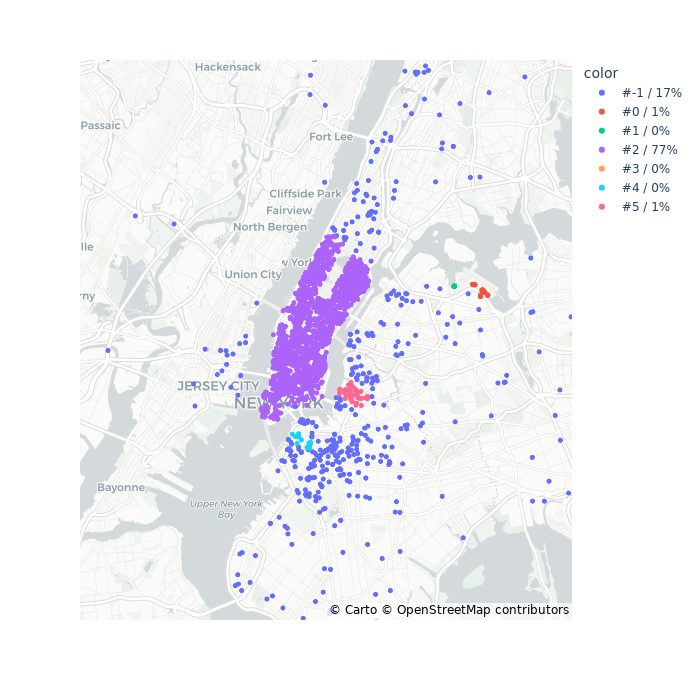

In [16]:
print("Example for a given timeframe (without hiding outliers) :")
timeframe_example = timeframe_summary_list[50]
display(timeframe_example)
fig = px.scatter_mapbox(timeframe_example, lat = 'Lat', lon = 'Lon', 
                      mapbox_style="carto-positron", 
                      color = timeframe_example['cluster / % of demand'].astype(str), 
                      height = 700, zoom = 10
                     )
fig.show('png')

#### 3.2.3. Final visualizations

Figure created in figures/DBSCAN_clustering.html


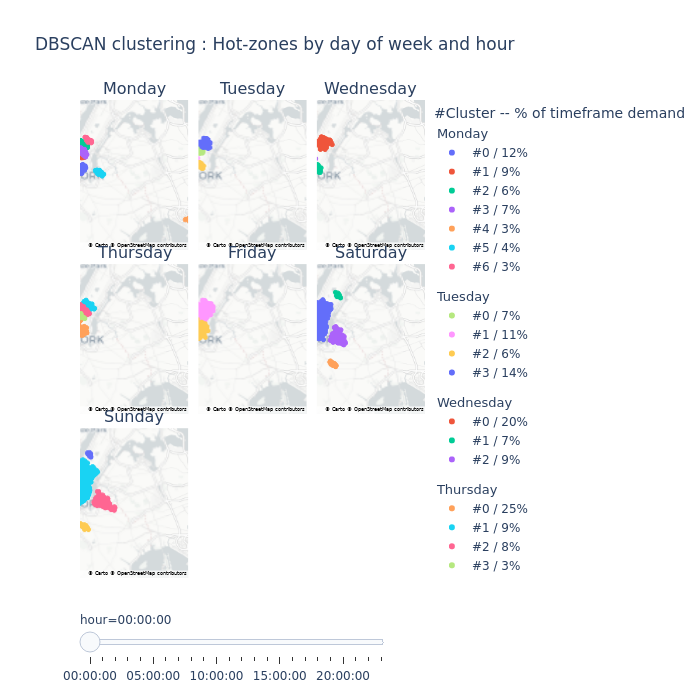

In [17]:
# Create one subplot per day of week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
figs = sp.make_subplots(rows = int(math.ceil(len(days_of_week)/3)), cols = 3, subplot_titles = days_of_week, 
                        specs = [[{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {'type':'mapbox'}, {'type':'mapbox'}],
                                 [{'type':'mapbox'}, {}, {}]],
                        horizontal_spacing = 0.03, vertical_spacing = 0.03)

# Set default mapbox display settings
default_mapbox_dict = {'center': {'lat': 40.712559, 'lon': -73.889029},
                       'style': 'carto-positron',
                       'zoom': 8.5
                      }

# Initialize each day mapbox
for day_index in range(len(days_of_week)):
    figs.update_layout({f'mapbox{day_index+1}' : default_mapbox_dict})

# Slider initialization
slider_dict = {'active': 0,
               'currentvalue': {'prefix': 'hour='},
               'len': 0.9,
               'pad': {'b': 10, 't': 30},
               'steps': []
              }

# Initialize timeframe, traces list

timeframe_index = 0
traces_hour_index = [] # initialize a list which will associate to each trace its corresponding hour index for later use in interactive mask (slider)

# Fill the data for each trace (1 trace per different {hour, day, cluster} combination existing in the data)
# 1. Loop on frames (hours)

hour_names = ["{:0>2d}:00:00".format(hour_index) for hour_index in range(24)] 
for hour_index in range(24):

    # 2. Loop on subplots (days of week)

    for day_index, day in enumerate(days_of_week):
        subplot_data = timeframe_summary_list[timeframe_index]
        hide_outliers_mask = subplot_data['cluster']!=-1 
        subplot_data = subplot_data[hide_outliers_mask] # hide outliers on the maps
        row_number = i//3 + 1
        col_number = i%3 + 1

        # 3. Loop on traces (clusters)

        for cluster in subplot_data['cluster'].unique():
            cluster_data = subplot_data[subplot_data['cluster']==cluster]
            if len(cluster_data['cluster / % of demand'].unique()) != 0:
                cluster_name = cluster_data['cluster / % of demand'].unique()[0]
            else: 
                cluster_name = 'no cluster found'
            data_dict = {
                'type' : 'scattermapbox',
                'text': hour_names[hour_index],
                'hoverinfo': 'all',
                'name': cluster_name,
                'subplot': f'mapbox{day_index+1}',
                'lat' : subplot_data['Lat'][subplot_data['cluster'] == cluster],
                'lon' : subplot_data['Lon'][subplot_data['cluster'] == cluster],
                'legendgrouptitle' : {'text' : day},
                'legendgroup' : day,
                'showlegend' : True,
                'visible' : False # set each trace default to invisible since the slider will set which trace is visible
            }
            if hour_index == 0:
                data_dict['visible'] = True # Set the traces of the first hour default to visible
            figs.add_trace(data_dict)
            traces_hour_index.append(hour_index)
            print(f"Trace created for Hour : {hour_index}, Day : {day}, Cluster : {cluster}")
            clear_output(wait = True)
        timeframe_index += 1

# Create steps of the slider

for hour_index in range(24):
    mask = [True if x == hour_index else False for x in traces_hour_index]
    step = {'args': [{'visible': mask},{'showlegend' : mask}],
            'label': hour_names[hour_index],
            'method': 'update'}
    slider_dict['steps'].append(step)
figs.layout.sliders = [slider_dict]

# Plot and save figure

figs.update_layout(height = 700, title_text = "DBSCAN clustering : Hot-zones by day of week and hour", legend_title_text = "#Cluster -- % of timeframe demand")
file_name = 'DBSCAN_clustering.html'
dir_name = 'figures'
path = f"{dir_name}/{file_name}"
figs.write_html(path) # saving interactive figure in html file
print(f'Figure created in {path}')
figs.show('png') # showing non-interactive preview for github

#### 3.2.4. Interpretations

This figure display allows to easily visually : 
- see the evolution of a cluster size in a given day as a function of time
- compare at a given hour the clusters localizations in each day of the week
- see on the legend for each the cluster the proportion of the timeframe demand it represents.  
 
_Note : **the timeframe demand is not to be confused with the mean demand along all timeframes that we used to calculate our min_samples hyperparameter**. You cannot compare the percentage of a cluster in a timeframe with a percentage from another timeframe, because the timeframe demand is not necessarily the same between the two._  
_However, as min_samples is the same for all timeframes, you can see for a given area if a cluster appears more in some timeframes than others, if a big cluster splits into several more little when changing the timeframe or if several clusters regroup into a big one. => **You can therefore still see visually the evolution of absolute demand along timeframes**_     

The clusters appearing give us some insights on where Uber should focus as a function of day of week and time : 
- **The area which is always with the highest demand is downtown/midtown Manhattan** because it is a place that regroups as well companies to work in as touristical venues and local nightlife spots 
- **The only time period in which this Manhattan area demand progressively drops is in very late night / very early morning (between 23h and 04h the morning after), except on weekend nights (friday and saturday)** for which the night life is lively.
- **From 5h AM, the demand in JFK airports area generally arises and then drops again in the late morning to give way to the one near LaGuardia airport. In the afternoon and evening these areas both represent hot-zones.**
- **The trendy neigborhoods of Brooklyn (particularly in Williamsburgh) stay lively in the afternoon and in the nights, especially on weekends.** 
 